# Image Segmentation with U-Net

Image segmentation is a computer vision technique that divides an image into segments where each pixel in the image is mapped to an object. By parsing an image’s complex visual data into specifically shaped segments, image segmentation enables faster, more advanced image processing.

It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center><u><b>Figure 1</u></b>: Example of a segmented image<br></center></caption>

Image segmentation techniques range from simple, intuitive heuristic analysis to the cutting edge implementation of deep learning. Conventional image segmentation algorithms process high-level visual features of each pixel, like color or brightness, to identify object boundaries and background regions. Machine learning, leveraging annotated datasets, is used to train models to accurately classify the specific types of objects and regions an image contains.

## Use Cases
**Autonomous Driving**

Segmentation models are used to identify road patterns such as lanes and obstacles for safer driving.

**Background Removal**

Image Segmentation models are used in cameras to erase the background of certain objects and apply filters to them.

**Medical Imaging**

Image Segmentation models are used to distinguish organs or tissues, improving medical imaging workflows. Models are used to segment dental instances, analyze X-Ray scans or even segment cells for pathological diagnosis.

Let's check this video from Nvidia to learn how image segmentation improves self-driving cars detection.

<video controls src="videos/How AI Helps Autonomous Vehicles See Outside the Box - NVIDIA DRIVE Labs Ep. 14.mp4">

You'll be building your own U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. 

As you might imagine, region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger. 

At the end of this notebook, you will be abble to:

* Build your own U-Net
* Explain the difference between a regular CNN and a U-net
* Implement semantic image segmentation on the CARLA self-driving car dataset
* Apply sparse categorical crossentropy for pixelwise prediction

Onward, to this grand and glorious quest!

# Now Let's build our own image segmentation model !

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [1]:
import numpy as np
import imageio
import os

import tensorflow as tf 
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<a name='2'></a>
## 2 - Load and Split the Data

The dataset used in the notebook is Lyft Udacity challenge dataset, which contains street scene images generated using CARLA driving simulator, including pixel-level annotations for different objects, such as cars, pedestrians, and buildings.

Using datasets generated from the CARLA simulator can be a valuable tool for training and testing self-driving car algorithms. CARLA provides a realistic environment for generating large amounts of labeled data with ground truth information, allowing for the development and evaluation of complex computer vision and machine learning models. The biggest benefit of using CARLA for is that it solves the issue of data scarcity, which is a major challenge in the development of self-driving car technology.

While 3D generated data from simulators like CARLA can be helpful for training and testing self-driving car models, it is important to recognize that it cannot fully replace real-world data. Real-world data contains complex and unpredictable scenarios that are difficult to replicate in a simulated environment. However, incorporating 3D generated data into the training pipeline can help improve the robustness and performance of the models, especially in scenarios that are difficult or dangerous to replicate in the real world. It is demonstrated in the notebook how to save the model, how to load it and make it ready to train on some other dataset.

This dataset is recorded on 13 classes

### 2.1. Load the images and masks from their directories¶
In this data preparation step, we will:

- Create 2 lists containing the paths of images and masks
- Split the lists into training, validation and test sets

**2.1.1. Create lists containing the paths of images and masks**
In this step, we will

- Create a list that contains all the paths to all directories in the main directory (a list that contains the path to dataA, dataB, dataC, dataD, and dataE)
- Create a function to iterate over all the direcory paths where our data are located (list in 1.) and return the list of the image paths in those directories.
- Create lists of image and mask paths
- Preview some masked and unmasked images by reading them from their paths

**IMPORTANT:** download the dataset from the following link: https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge

you can download just on chunk (A, B, C, ...), it should be enough to get a decent model for this demonstration. Fix the path variables accordingly.

**A. Create a list that contains all the paths to all directories in the main directory (a list that contains the path to dataA, dataB, dataC, dataD, and dataE)**

In [2]:
# image_dir = ["../dataset/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
# mask_dir = ["../dataset/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]
path = ''
image_dirs = [os.path.join(path, './carla-capture/CameraRGB/')]
mask_dirs = [os.path.join(path, './carla-capture/CameraSeg/')]

**Create a function to iterate over all the direcory paths where our data are located (list in 2.1.1.) and return the list of the image paths in those directories**

In [3]:
def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths

In [4]:
image_paths = list_image_paths(image_dirs)
mask_paths = list_image_paths(mask_dirs)


number_of_images, number_of_masks = len(image_paths), len(mask_paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")


1. There are 1000 images and 1000 masks in our dataset
2. An example of an image path is: 
 ./carla-capture/CameraRGB/F61-1.png
3. An example of a mask path is: 
 ./carla-capture/CameraSeg/F61-1.png


### Check out the some of the unmasked and masked images from the dataset:


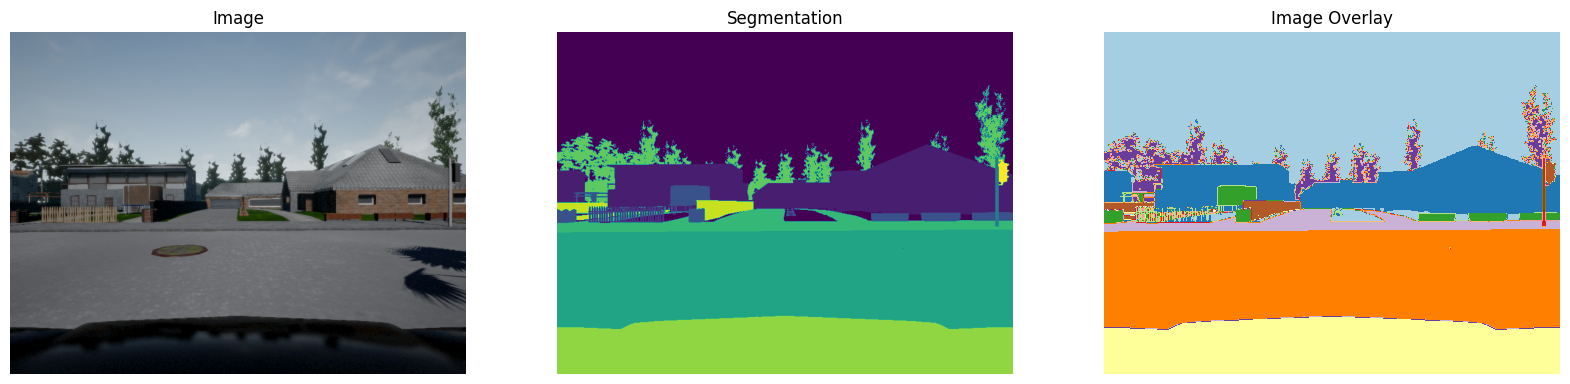

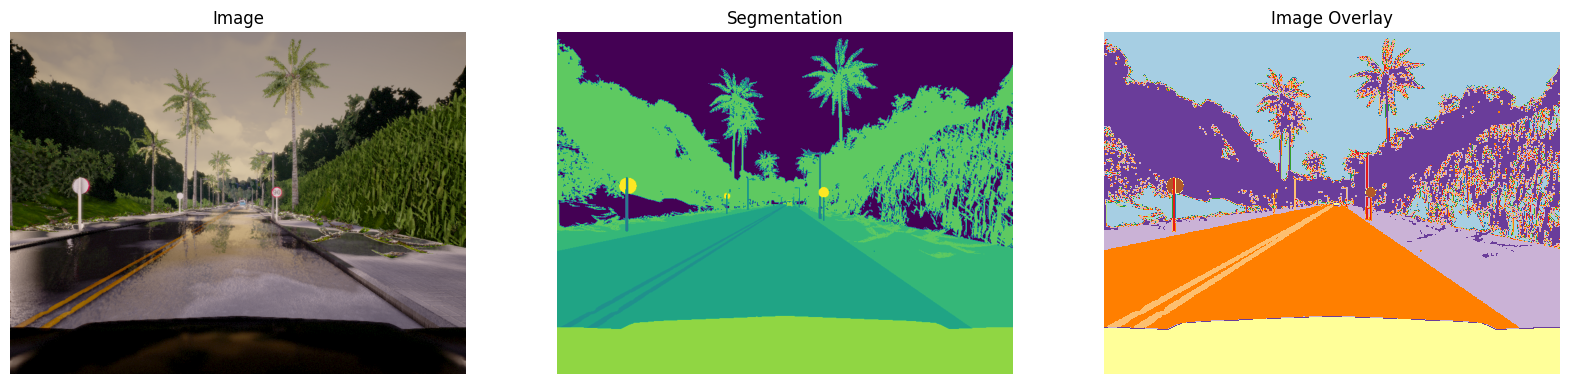

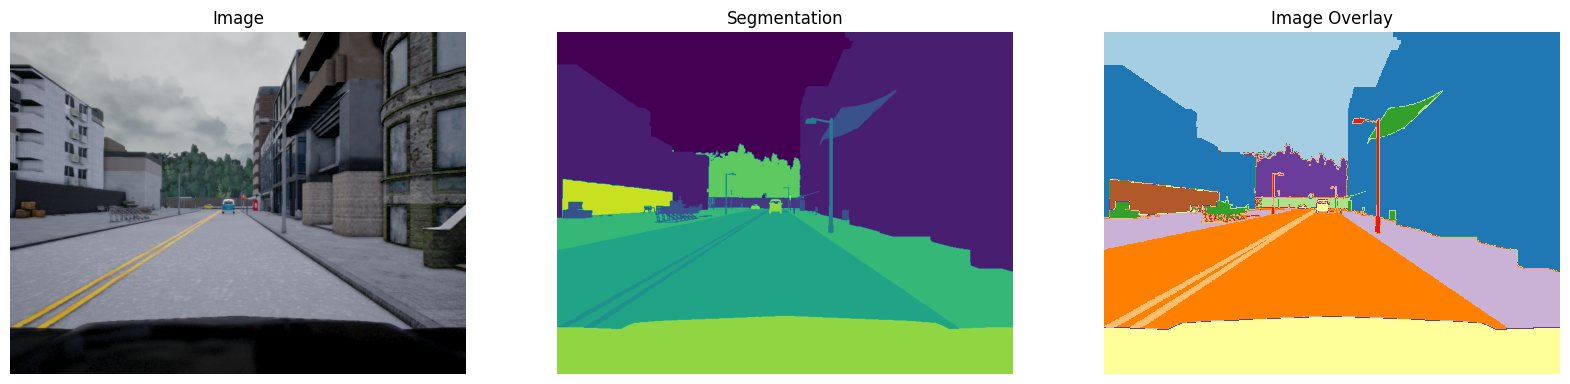

In [5]:
import random
number_of_samples = len(image_paths)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)
    img = imageio.imread(image_paths[N])
    mask = imageio.imread(mask_paths[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")    
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Image Overlay')
    arr[2].axis("off")

**2.1.2. Split the image and mask paths into training, validation, and test sets**

In [6]:
# First split the image paths into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.8, random_state=0)

# Keep part of the validation set as test set
validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size = 0.8, random_state=0)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(validation_image_paths)} images in the Validation Set')
print(f'There are {len(test_image_paths)} images in the Test Set')

There are 800 images in the Training Set
There are 160 images in the Validation Set
There are 40 images in the Test Set


<a name='2-1'></a>
### 2.2. - Create a data pipeline to read and preprocess our data

We will be using the tf.data.Dataset API to load our images and masks for our model to process. The Dataset API allows us to build an asynchronous, highly optimized data pipeline to prevent our GPU from data starvation. It loads data from the disk (images or text), applies optimized transformations, creates batches and sends it to the GPU.

To do this, we will

1. Create a function to read image and mask paths and return equivalent arrays
2. Create a data generator function to read and load images and masks in batches
3. Create data pipelines for the training, validation and test sets using both functions
4. Preview sample images and their segmentations from the three dataset categories

**2.2.1. Create a function to read image and mask paths and return equivalent arrays**

The read_image function will

1. Read an image and its mask from their paths
2. Convert the digital image and its mask to image arrays
3. Normalize the datasets
4. Resize the image and its masks to a desired dimension

Normally, you normalize your image values by dividing them by `255`. This sets them between `0` and `1`. However, using `tf.image.convert_image_dtype` with `tf.float32` sets them between `0` and `1` for you, so there's no need to further divide them by `255`.

After that, resize both image and mask to (192, 256). It is important to use 'nearest' method so that mask classes do not get distorted.

The (192, 256) image size was chosen to mimick the original resulution of the image (600x800). It is also important that both numbers can be divided by 2 multiple times, making it easier to design the U-Net architecture.

In [7]:
IMG_SHAPE = [192, 256]

In [8]:
def read_image(image_path, mask_path):
    
    # Read image from file
    image = tf.io.read_file(image_path)
    
    # Decode image using png format to an array
    image = tf.image.decode_png(image, channels=3)
    
    # Convert from int to float, this will scale the value to range (0, 1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize to required shape
    # Nearest neighbor interpolation works by simply selecting the nearest pixel from the original image to fill in the values of the new resized image.
    image = tf.image.resize(image, IMG_SHAPE, method='nearest')

    # same process for masks
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, IMG_SHAPE, method='nearest')
    
    return image, mask

**2.2.2. Create a data generator function to read and load images and masks in batches**

In [9]:
def data_generator(image_paths, mask_paths, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
    
    return dataset

**2.2.3. Create data pipelines for the training, validation and test sets using both functions**

In [10]:
batch_size = 8

train_dataset = data_generator(train_image_paths, train_mask_paths, batch_size)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, batch_size)

<a name='3'></a>
## 3 - U-Net 

**U-Net architecture**, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

<a name='3-1'></a>
### 3.1 - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**1. Contracting path (Encoder containing downsampling steps):**

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 same padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

During the contracting process, convolution outputs are stored in a separate variable before size reduction (pooling of features). This is passed to the expanding blocks during the decoding process as feature map.

**2. Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**3. Expanding path (Decoder containing upsampling steps):**

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**4. Final Feature Mapping Block:**

In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

#### Important Note: 
The figures shown for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints, we will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture.

<a name='3-2'></a>
### 3.2 - Building the U-Net Model

To design our model, we will carry out the following steps

1. Define a function for an encoding block. The function will return the next layer output and the skip connection output for the corresponding block in the model
2. Define a function for a decoding block. This function will merge the skip-connection input with the previous layer, process it, and return an output
3. Develop a model using both the encoding and decoding blocks output

<a name='3-2-1'></a>
#### 3.2.1 - Encoder (Downsampling Block) 
<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with **BatchNormalization** and **ReLU** activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [11]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """ 
    conv = keras.layers.Conv2D(filters=n_filters, # Number of filters
                  kernel_size=3,   # Kernel size   
                  padding='same',
                  use_bias=False,
                  kernel_initializer='he_normal')(inputs)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation("relu")(conv)
    
    conv = keras.layers.Conv2D(filters=n_filters, # Number of filters
                  kernel_size=3,   # Kernel size
                  padding='same',
                  use_bias=False,
                  kernel_initializer='he_normal')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation("relu")(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = keras.layers.Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = keras.layers.MaxPooling2D((2,2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

<a name='3-2-2'></a>
### 3.2.2 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer. You can read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


For the function `upsampling_block`: 
* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block you completed previously
* Your `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer. 

This block is also where you'll concatenate the outputs from the encoder blocks, creating skip connections. 

* Concatenate your Conv2DTranspose layer output to the contractive input, with an `axis` of 3. In general, you can concatenate the tensors in the order that you prefer. But for the grader, it is important that you use `[up, contractive_input]`

For the final component, set the parameters for two Conv2D layers to the same values that you set for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding). 


In [12]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = keras.layers.Conv2DTranspose(
                 filters=n_filters,    # number of filters
                 kernel_size=3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = keras.layers.concatenate([up, contractive_input], axis=3)
    
    conv = keras.layers.Conv2D(n_filters,                   # Number of filters
                 kernel_size=3,                             # Kernel size
                 padding='same',
                 use_bias=False,
                 kernel_initializer='he_normal')(merge)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation("relu")(conv)
    
    conv = keras.layers.Conv2D(filters=n_filters,           # Number of filters
                 kernel_size=3,                             # Kernel size
                 padding='same',
                 use_bias=False,
                 kernel_initializer='he_normal')(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation("relu")(conv)
    
    return conv

<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 13. That's because there are 13 possible labels for each pixel in this self-driving car dataset. 

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block4`, add `dropout_prob` of 0.3
* For the final conv_block, set `dropout_prob` to 0.3 again, and turn off max pooling  

For the second half:

* Use cblock5 as expansive_input and cblock4 as contractive_input, with `n_filters` * 8. This is your bottleneck layer. 
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that you must use the second element of the contractive block before the max pooling layer. 
* At each step, use half the number of filters of the previous block
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and "same" padding. The output of `conv10` is the output of your model. 

In [13]:
def unet_model(input_size=(192, 256, 3), n_filters=32, n_classes=13):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = keras.layers.Input(input_size)
    
    ####################################
    # Contracting Path (encoding)
    ####################################
    
    # Add a conv_block with the inputs of the unet_ model and n_filters
    conv1, skip1 = conv_block(inputs=inputs, n_filters=n_filters)
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    conv2, skip2 = conv_block(conv1, n_filters*2)
    conv3, skip3 = conv_block(conv2, n_filters*4)
    
    # Include a dropout_prob of 0.3 for this layer
    conv4, skip4 = conv_block(conv3, n_filters*8, dropout_prob=0.3)
    
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    conv5, skip5 = conv_block(conv4, n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    ####################################
    # Expanding Path (decoding)
    ####################################
    
    # Add the first upsampling_block.
    # Use the conv5 as expansive_input and skip4 as contractive_input and n_filters * 8
    up6 = upsampling_block(conv5, skip4,  n_filters*8)
    
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    up7 = upsampling_block(up6, skip3,  n_filters*4)
    up8 = upsampling_block(up7, skip2,  n_filters*2)
    up9 = upsampling_block(up8, skip1,  n_filters)

    conv9 = keras.layers.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(up9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = keras.layers.Conv2D(filters=n_classes, kernel_size=1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [14]:
img_height = 192
img_width = 256
num_channels = 3
filters = 32
n_classes = 13

unet = unet_model((img_height, img_width, num_channels), filters, n_classes)

### Check out the model summary below! 

In [15]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

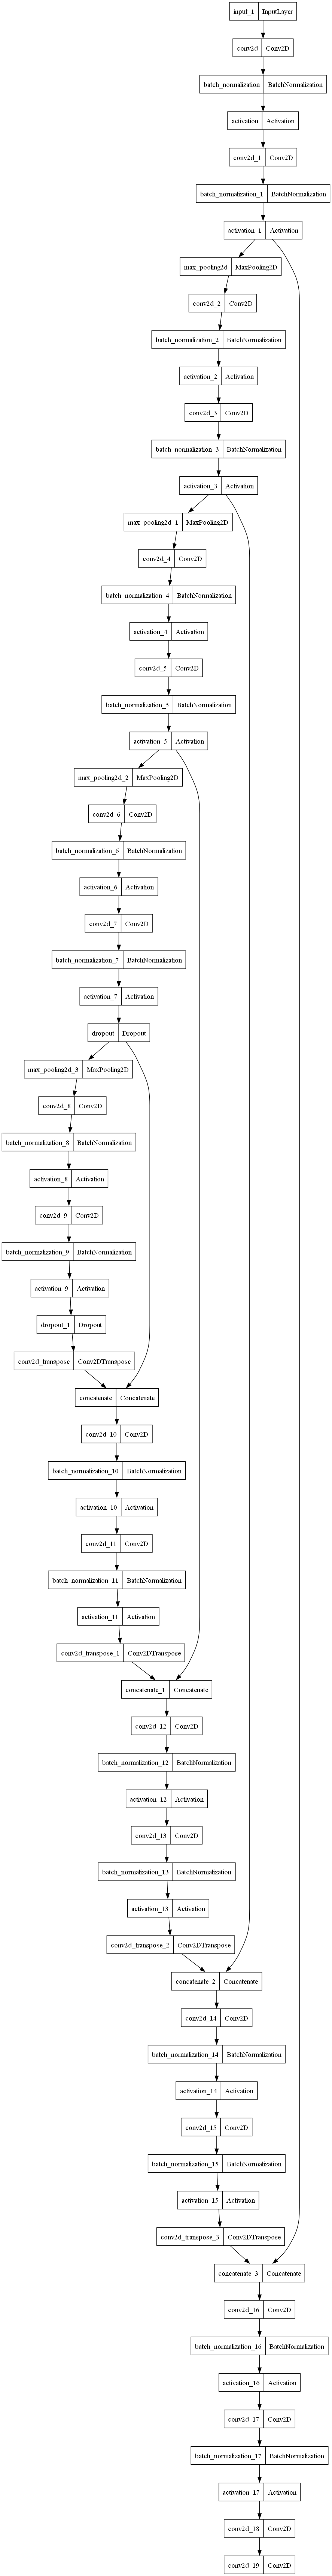

In [16]:
tf.keras.utils.plot_model(unet)

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [17]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

epochs = 30

<a name='4'></a>
## 4 - Train the Model

### 4.1 - Fit model

In [18]:
history = unet.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [early_stopping,],
                    shuffle = True)

Epoch 1/30
100/100 [==============================] - 38s 292ms/step - loss: 0.6457 - accuracy: 0.8125 - val_loss: 1.7179 - val_accuracy: 0.6366
Epoch 2/30
100/100 [==============================] - 24s 238ms/step - loss: 0.2707 - accuracy: 0.9198 - val_loss: 0.7677 - val_accuracy: 0.7945
Epoch 3/30
100/100 [==============================] - 24s 237ms/step - loss: 0.2003 - accuracy: 0.9386 - val_loss: 0.2708 - val_accuracy: 0.9113
Epoch 4/30
100/100 [==============================] - 25s 251ms/step - loss: 0.1652 - accuracy: 0.9486 - val_loss: 0.2363 - val_accuracy: 0.9218
Epoch 5/30
100/100 [==============================] - 27s 270ms/step - loss: 0.1391 - accuracy: 0.9560 - val_loss: 0.2240 - val_accuracy: 0.9330
Epoch 6/30
100/100 [==============================] - 28s 277ms/step - loss: 0.1206 - accuracy: 0.9612 - val_loss: 0.1578 - val_accuracy: 0.9484
Epoch 7/30
100/100 [==============================] - 28s 284ms/step - loss: 0.1466 - accuracy: 0.9534 - val_loss: 0.2332 - val_ac

### 4.2 - Plot model accuracy

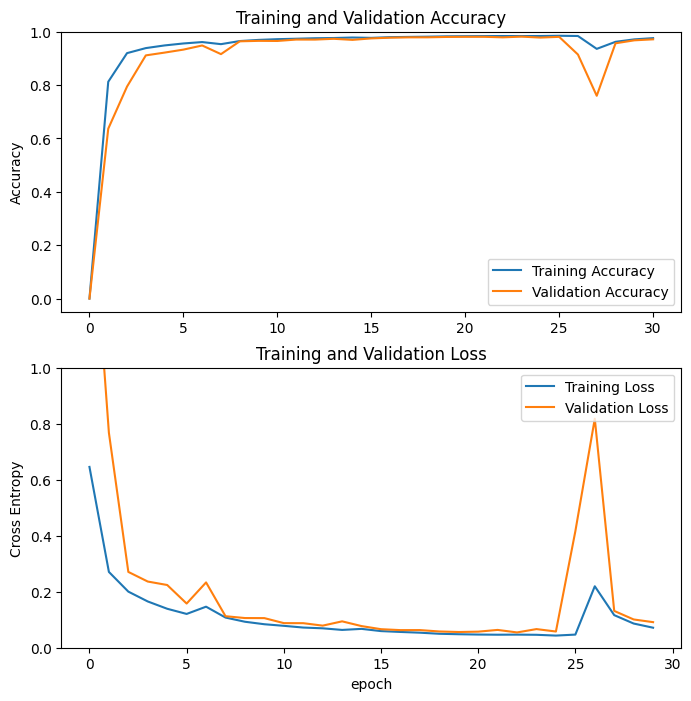

In [19]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
unet.save('model/carla-image-segmentation-model.h5')

### 4.3 - Compute Model Accuracy

In [23]:
train_loss, train_accuracy = unet.evaluate(train_dataset, batch_size = 32)
validation_loss, validation_accuracy = unet.evaluate(validation_dataset, batch_size = 32)
test_loss, test_accuracy = unet.evaluate(test_dataset, batch_size = 32)

5/5 [==============================] - 3s 183ms/step - loss: 0.0889 - accuracy: 0.9722


In [24]:
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 97.32%
Model Accuracy on the Validation Dataset: 97.15%
Model Accuracy on the Test Dataset: 97.22%


## 6. Predict image segmentations using the trained Model

<a name='4-1'></a>
### 6.1 - Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [ ]:
unet = keras.models.load_model('model/carla-image-segmentation-model.h5')

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask[0]

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [19]:
def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [20]:
def show_predictions(dataset, num):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
        pred_mask = unet.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 0s 55ms/step


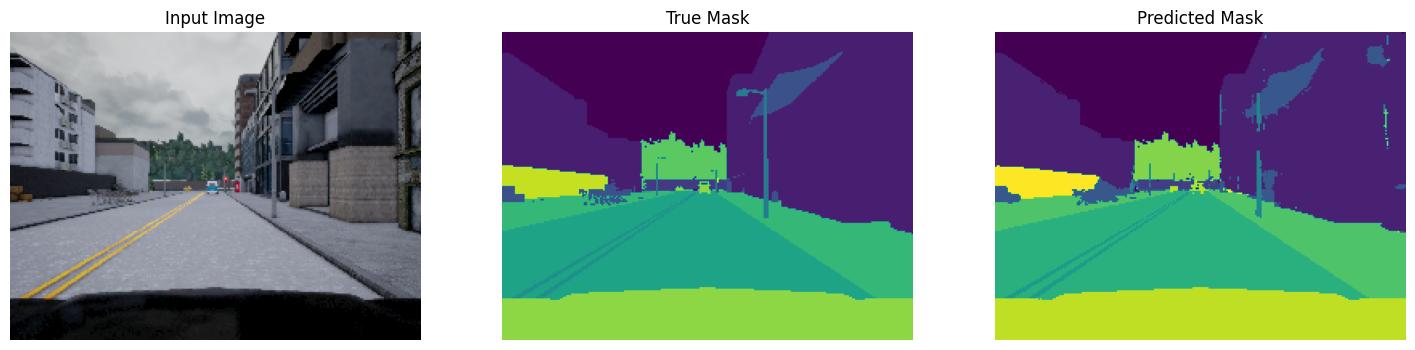

1/1 [==============================] - 0s 38ms/step


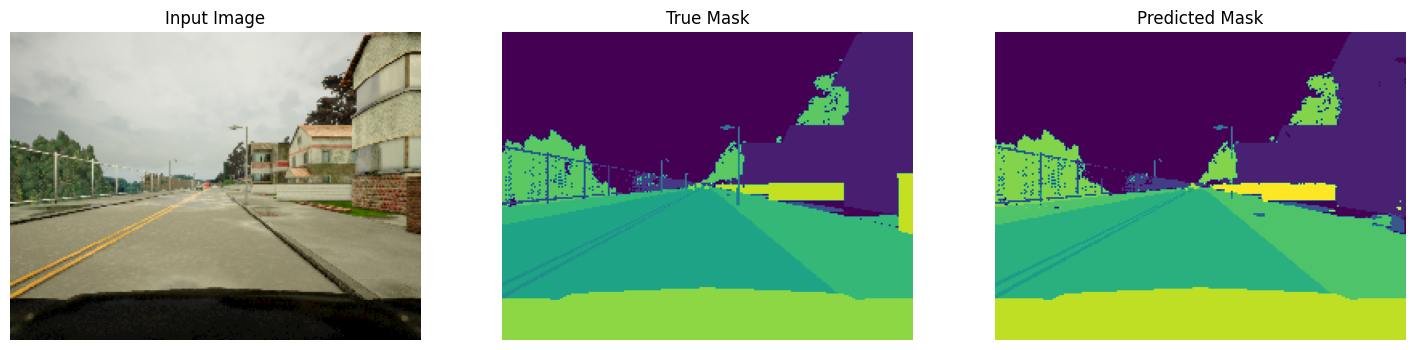

1/1 [==============================] - 0s 60ms/step


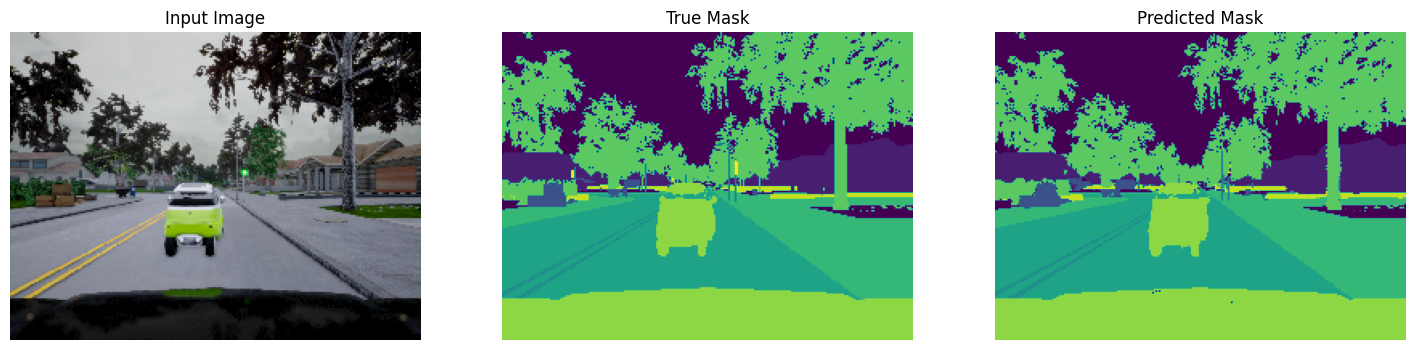

1/1 [==============================] - 0s 55ms/step


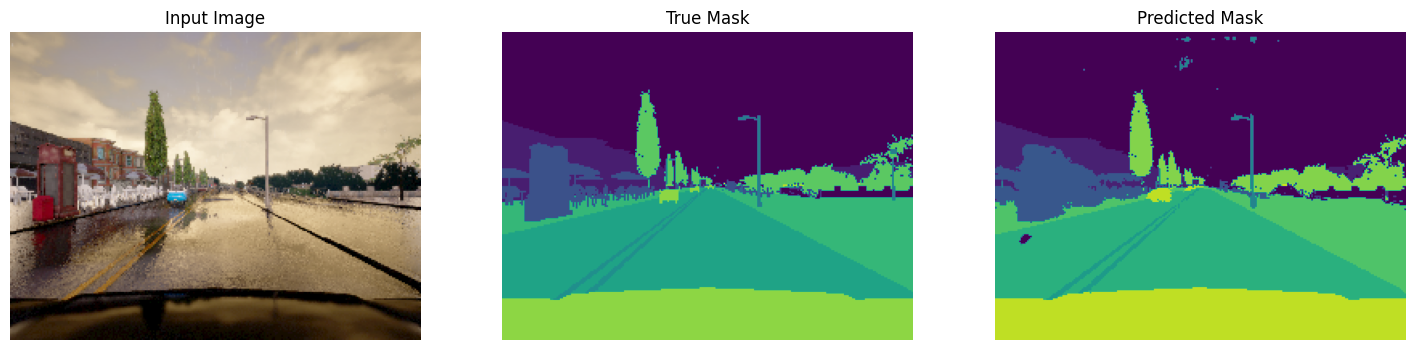

1/1 [==============================] - 0s 47ms/step


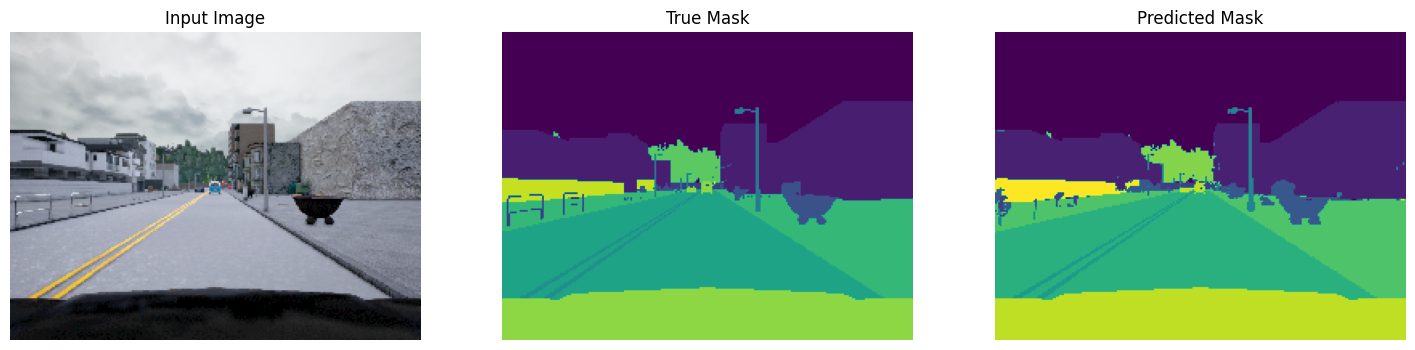

1/1 [==============================] - 0s 62ms/step


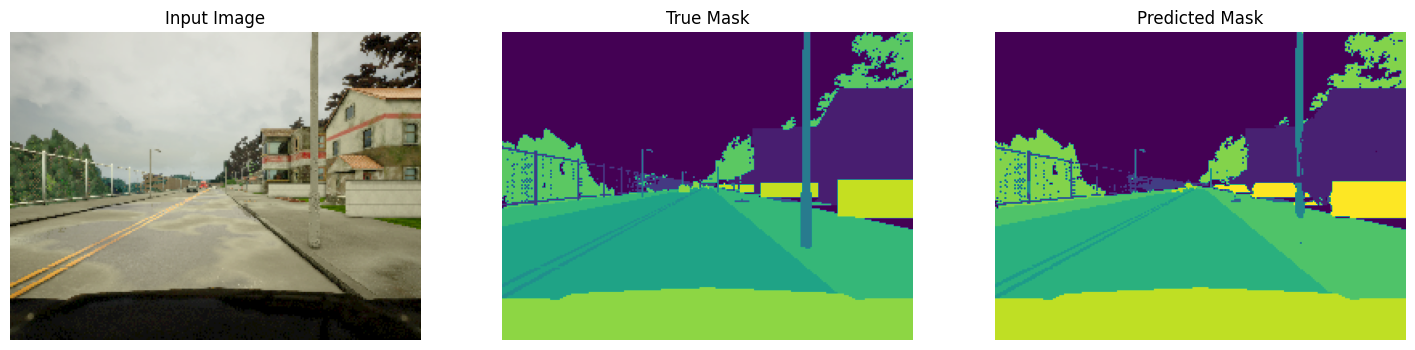

In [21]:
show_predictions(train_dataset, 6)

### Conclusion 

You've come to the end of this assignment. Awesome work creating a state-of-the art model for semantic image segmentation! This is a very important task for self-driving cars to get right. Elon Musk will surely be knocking down your door at any moment. ;) 

**What you should remember**: 

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net

## 5. Model Evaluation (EXTRA)

Model Evaluation is an integral part of the model development process. It helps to find the best model that represents our data and how well the chosen model will work in the future. For classification tasks, precision and recall are the popular choice metrics used in addition with model accuracy to evaluate model performance since model accuracy is not always sufficient to judge if a model is optimal or not (especially if our dataset is skewed). The same rule applies to most dense prediction tasks like image segmentation where the goal is to simplify and/or change the representation of an image into classes that is more meaningful and easier to analyze.

Since the goal of our model is to partition an input image into various classes, it is often difficult to know if our model struggles to optimally partition one or more classes since it doesn't always reflect in the model accuracy, neither can it easily detected by the eyes. Hence, there is a need for supplementary metrics to evaluate model performance.

In this project, we will be using recall,precision, specificity, true detection rate (TDR), Intersection over Union (IoU), and F1-score as supplementary metrics to evaluate our model performance. These metrics were computed by identifying the variables true positive (TP), true negative (TN), false positive (FP), and false-negative (FN) by calculating the confusion matrix between the predicted segmentations and the ground truth segmentations. The expressions for these metrics are defined as:

- Precision = TP/(TP + FP)
- Recall/Sensitivity = TP/(TP + FN)
- Specificity = TN/(TN + FP)
- True Detection Rate (TDR) = 1 - (FN/(TP + FN))
- Intersection over Union (IoU)/Jaccard Similarity = TP/(TP + FP + FN)
- F1-score(JS)/Dice coefficient = 2 ((Precision Recall)/(Precision + Recall))

To carry out these evaluations, we will:

1. Create segmentations/masks of images in our dataset
2. Evaluate predicted segmentations


### 5.1 Create Segmentations/Masks of Images in our Dataset

In [23]:
def create_mask_eval(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)
        
    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)
        
    return true_masks, predicted_masks    

In [24]:
true_train_masks, predicted_train_masks = create_mask_eval(train_dataset, unet)
true_validation_masks, predicted_validation_masks = create_mask_eval(validation_dataset, unet)
true_test_masks, predicted_test_masks = create_mask_eval(test_dataset, unet)

1/1 [==============================] - 0s 61ms/step


In [26]:
from eval_utils import *

### 5.2 Evaluate Predicted Segmentations (Optional, for extra research)

**5.2.1. Evaluate predicted segmentations of the training images**

In [29]:
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=13)

show_evaluations(model_evaluation_on_train_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.8,0.87,1.0,0.73,0.8,0.81
1,Class 1,0.99,0.98,0.99,0.98,0.99,0.98
2,Class 2,0.93,0.97,1.0,0.91,0.93,0.95
3,Class 3,0.77,0.76,1.0,0.61,0.77,0.76
4,Class 4,0.86,0.6,0.99,0.55,0.86,0.71
5,Class 5,0.15,0.6,1.0,0.14,0.15,0.24
6,Class 6,0.72,0.72,1.0,0.56,0.72,0.72
7,Class 7,0.94,0.99,1.0,0.93,0.94,0.96
8,Class 8,0.99,0.99,1.0,0.99,0.99,0.99
9,Class 9,0.96,0.98,1.0,0.94,0.96,0.97


**4.2.2. Evaluate predicted segmentations of the validation images**

In [28]:
model_evaluation_on_validation_dataset = evaluate_model(true_validation_masks, predicted_validation_masks, n_classes=13)

show_evaluations(model_evaluation_on_validation_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.79,0.86,1.0,0.72,0.79,0.8
1,Class 1,0.99,0.98,0.99,0.98,0.99,0.98
2,Class 2,0.93,0.97,1.0,0.9,0.93,0.95
3,Class 3,0.74,0.73,1.0,0.58,0.74,0.73
4,Class 4,0.85,0.59,0.99,0.53,0.85,0.7
5,Class 5,0.18,0.64,1.0,0.17,0.18,0.28
6,Class 6,0.66,0.71,1.0,0.52,0.66,0.68
7,Class 7,0.94,0.99,1.0,0.92,0.94,0.96
8,Class 8,0.99,0.99,1.0,0.99,0.99,0.99
9,Class 9,0.96,0.97,1.0,0.93,0.96,0.96


**4.2.3. Evaluate predicted segmentations of the test images**

In [27]:
model_evaluation_on_test_dataset = evaluate_model(true_test_masks, predicted_test_masks, n_classes=13)

show_evaluations(model_evaluation_on_test_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.78,0.81,1.0,0.71,0.78,0.78
1,Class 1,0.99,0.99,0.99,0.98,0.99,0.99
2,Class 2,0.92,0.97,1.0,0.9,0.92,0.94
3,Class 3,0.75,0.72,1.0,0.58,0.75,0.73
4,Class 4,0.84,0.59,0.99,0.53,0.84,0.69
5,Class 5,0.0,0.0,1.0,0.0,0.0,0.0
6,Class 6,0.72,0.7,1.0,0.55,0.72,0.71
7,Class 7,0.93,0.99,1.0,0.92,0.93,0.96
8,Class 8,0.99,0.99,1.0,0.99,0.99,0.99
9,Class 9,0.96,0.97,1.0,0.93,0.96,0.96
